# Rosenbrock function

Rosenbrock function (2D):
$$
f(x, y) = (1 - x)^2 + b \cdot (y - x^2)^2
$$
$$
b = 100
$$
- Global minimum: $f(x, y) = 0$ at $(x, y) = (1, 1)$
- Non-convex, commonly used to test optimization algorithms
- badness parameter $b$

### Aspects
- starting point with large gradients
- turning in the valley into the slow descent direction
- gradient in one direction is a multitude larger than the other
- progress in the valley
- dealing with change of the curvature near $x=0$
- approaching optimum
- convergence


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import RK45
import adambash

In [2]:
# Rosenbrock function
def rosenbrock(x, y, a=1, b=100):
    return (a - x)**2 + b*(y - x**2)**2

In [3]:
# Initial point and optimization
x0 = np.array([-1, 2])
# Plot the Rosenbrock function and path
x = np.linspace(-2, 2, 400)
y = np.linspace(-1, 3, 400)
X, Y = np.meshgrid(x, y)
Z = rosenbrock(X, Y)

In [23]:
def prepPlot():
    plt.figure(figsize=(10, 6))
    levels = np.array([i**2 for i in range(21)])
    plt.contour(X, Y, Z, levels=levels, cmap='rainbow')
    plt.plot(1, 1, 'bo', label='Minimum (1,1)')
    plt.plot(-1,2,'co',label='Start (-1,2)')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Rosenbrock Function, levels')
    plt.grid(True)

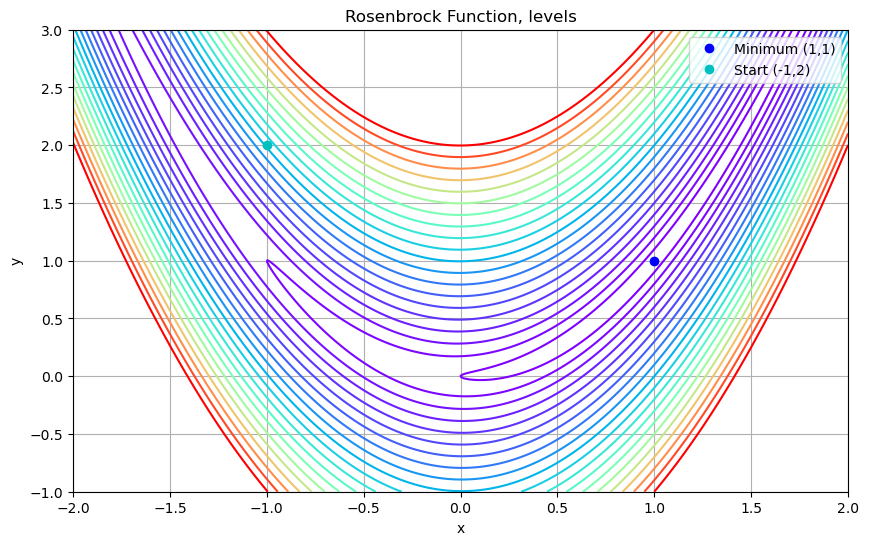

In [24]:
prepPlot()
plt.legend()
plt.show()

- it's a valley: blue=down, red=high up
- Left green: starting point with descent direction down left $f(x,y)=104$
- Right blue: optimum in a long valley - $f(x,y)= 0$
- level lines (deformed circles) at $ 0,1,4,9,..,400$
- a line between the 2 points goes over a hill

In [25]:
# Gradient of the Rosenbrock function
def grad_rosenbrock(xy, a=1, b=100):
    x, y = xy
    dx = 2*(x-a) - 4*b*x*(y - x**2)
    dy = 2*b*(y - x**2)
    return np.array([dx, dy])

In [7]:
# Steepest descent method
def steepest_descent(f_grad, x0, lr=0.001, max_iter=100, tol=1e-6):
    x = x0
    path = [x0.copy()]
    for i in range(max_iter):
        grad = f_grad(x)
        x_new = x - lr * grad
        if np.linalg.norm(x_new) > 20:
            break
        path.append(x_new.copy())
        if np.linalg.norm(x_new - x) < tol:
            break
        x = x_new
    return np.array(path)

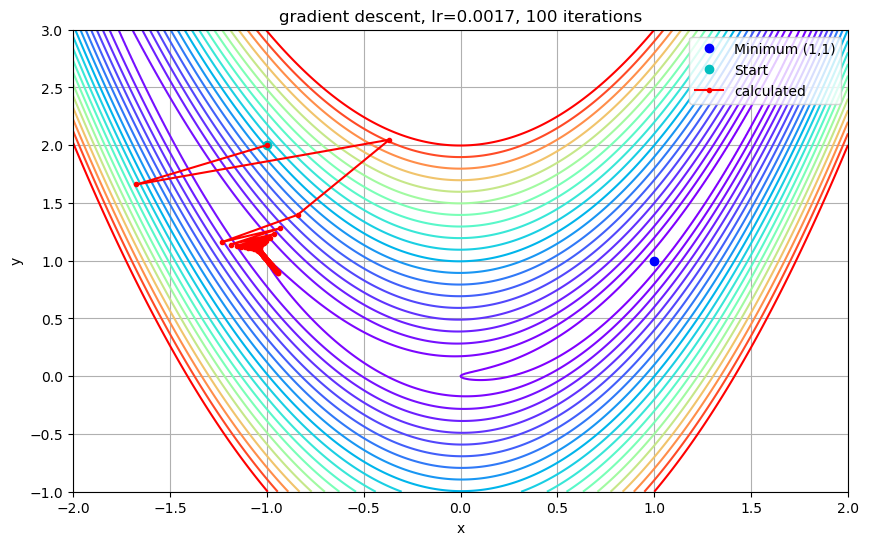

In [8]:
prepPlot()
path = steepest_descent(grad_rosenbrock, x0, lr=0.0017, max_iter=100)
plt.plot(path[:, 0], path[:, 1], 'r.-', label='calculated')
plt.title('gradient descent, lr=0.0017, 100 iterations')
plt.legend()
plt.show()

### common problem
- stagnation, stopping too early
- cannot maintain a "momentum" due to the method being momentum-free

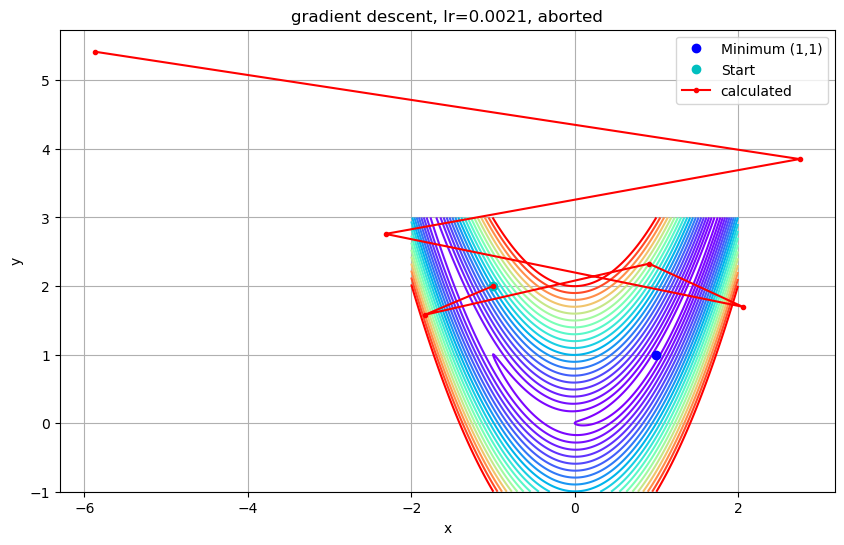

In [9]:
prepPlot()
path = steepest_descent(grad_rosenbrock, x0, lr=0.0021, max_iter=100)
plt.plot(path[:, 0], path[:, 1], 'r.-', label='calculated')
plt.title('gradient descent, lr=0.0021, aborted')
plt.legend()
plt.show()

### common problem
- starting outside the convergence zone
- problematic when function contains products of variables, $x_1 \cdot x_2 \cdot x_3$ &rarr; *exploding gradients*

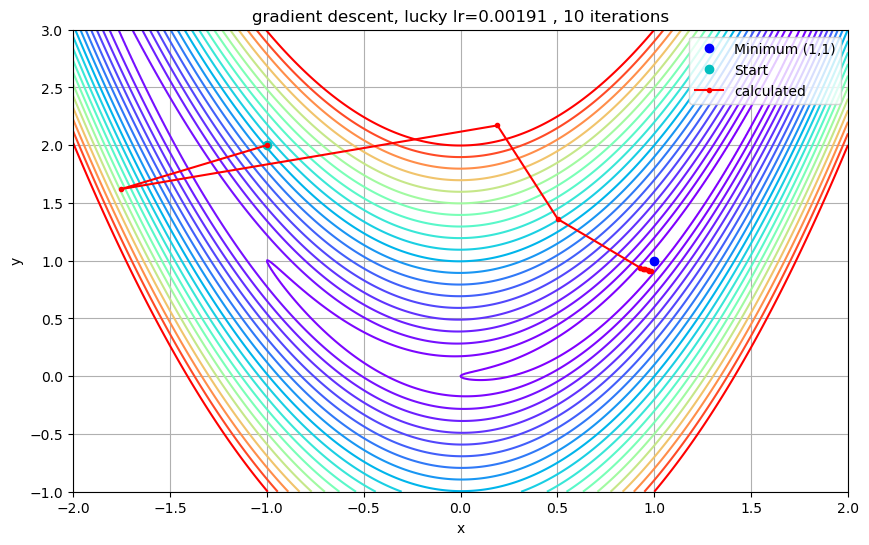

In [10]:
prepPlot()
path = steepest_descent(grad_rosenbrock, x0, lr=0.0019, max_iter=10)
plt.plot(path[:, 0], path[:, 1], 'r.-', label='calculated')
plt.title('gradient descent, lucky lr=0.00191 , 10 iterations')
plt.legend()
plt.show()

## Gradient flow

- gradient descent is like *explicit Euler integration*, why not take it further?
- need to change x according to the experienced gradient
$$ \dot{z} = g(t, z), z=(x,y) $$

#### Python code for gradienten:
~~~
dfdx = -2*(a - x) - 4*b*x*(y - x**2)
dfdy = 2*b*(y - x**2)
~~~
#### why it may work
- can find the optimum by integrating to infinity
- integration method Runge-Kutta, with additional time parameter

In [26]:
def gradFlow(t,xy):
    xy_bar = -1 * grad_rosenbrock(xy, 1, 100)
    return xy_bar

In [33]:
def RKLpath(max_iter=10):
    rk45 = RK45(gradFlow,0,x0.copy(), 10,max_step=20000)
    path=[x0.copy()]
    for s in range(max_iter):
        rk45.step()
        path.append(rk45.y.copy())
    return np.array(path)

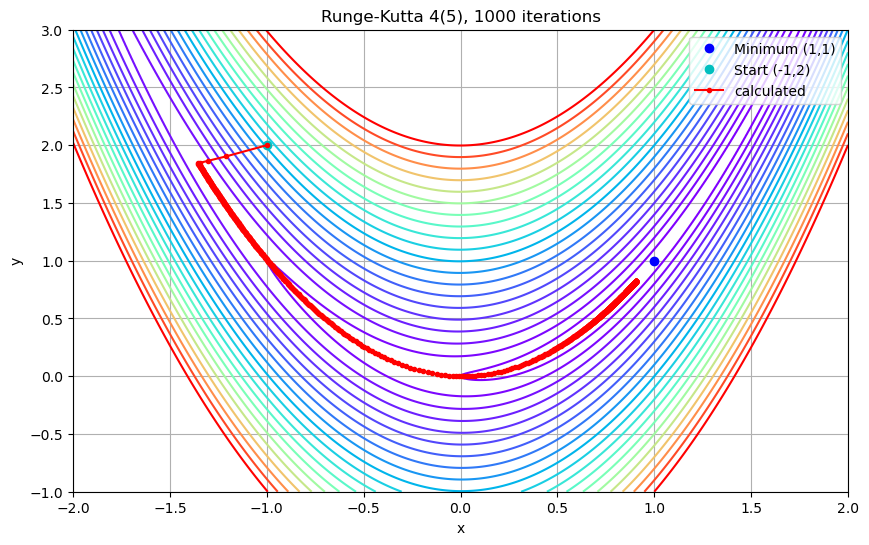

In [34]:
prepPlot()
# Solve using Runge-Kutta 4(5) (RK45)
path = RKLpath(1000)
plt.plot(path[:, 0], path[:, 1], 'r.-', label='calculated')
plt.title("Runge-Kutta 4(5), 1000 iterations")
plt.legend()
plt.show()

### Observations
- Each Runge Kutta step has 4 function evaluations at half stepsize and multiple estimation step.
- it is costly
- tries to find a monotonically decreasing path &rarr; hence has to stay at the bottom of the valley
- zigzagging with small steps through the valley

### Explicit higher order methods
#### Adam Bashfort schemes - up to order 6
- considers a polynomial approximation of the gradients
- not bound to decreasing objective values
- constant stepsize (not update size!)

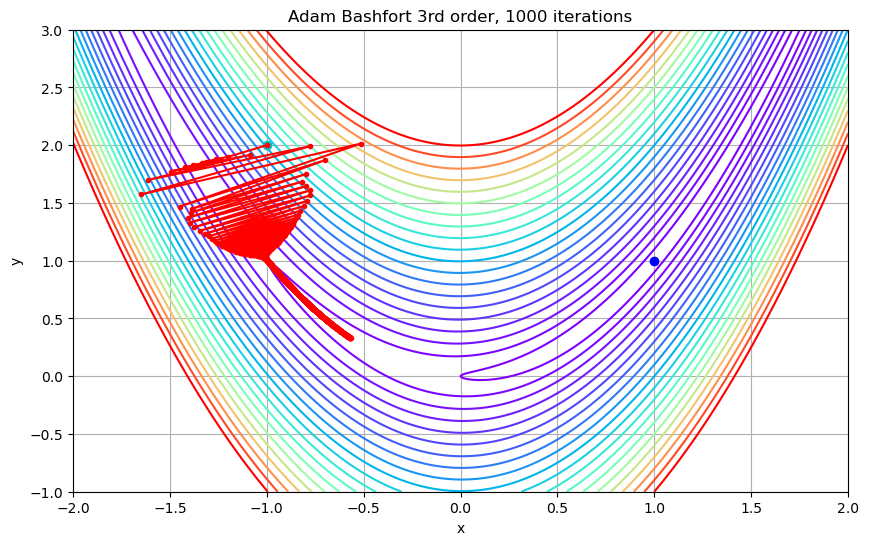

In [14]:
prepPlot()
ab= adambash.AdamBashfort(grad_rosenbrock, x0.copy(),0.0005)
path = ab.iterate(max_order=3, max_iter=1000 )
plt.plot(path[:, 0], path[:, 1], "r.-", label="calculated")
plt.title("Adam Bashfort 3rd order, 1000 iterations")
plt.show()


### From previous work (Set covering 2003)
- a method that works without explicit step length
- uses memory - the tail of recent steps &rarr; calculating next step size

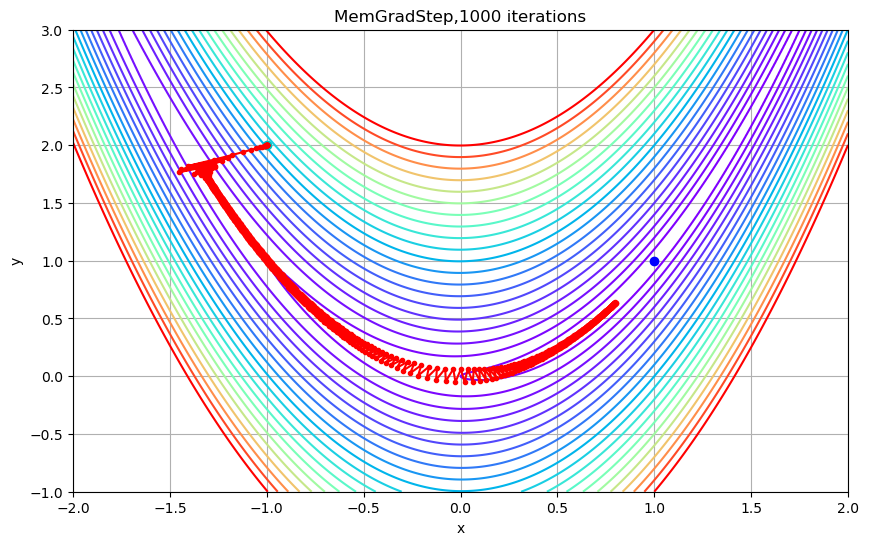

In [15]:
import memgradstep
prepPlot()
mgs=memgradstep.MemGradStep(grad_rosenbrock,x0.copy(),decay=0.5,memory=10)
path,obs =mgs.iterate(1000)
plt.plot(path[:,0],path[:,1],"r.-",label="calculated")
plt.title("MemGradStep,1000 iterations")
plt.show()

Text(0.5, 1.0, 'Step sizes')

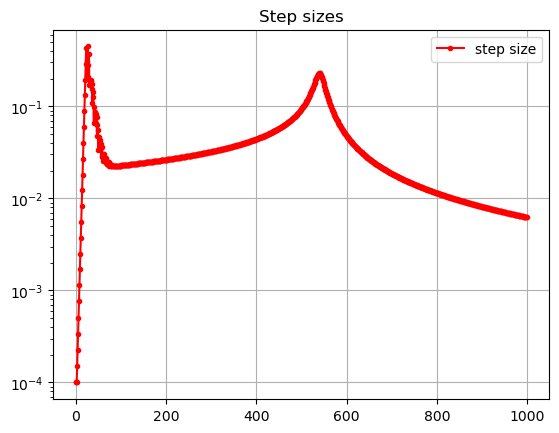

In [16]:
plt.semilogy(obs, "r.-", label="step size")
plt.legend()
plt.grid()
plt.title("Step sizes")

## Observations
- startup works really well, increasing step sizes up to level needed
- step size adjustment works
- too much zigzagging &rarr; too slow
- works very well for small *badness parameter values* $b$

## How about Adam?

In [17]:
import adamtest

Text(0.5, 1.0, 'Adam, 1000 iterations')

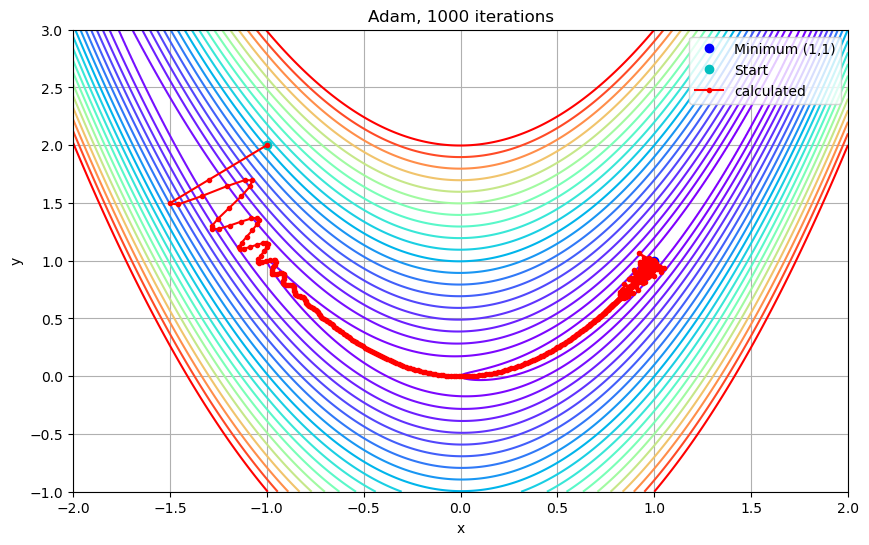

In [18]:
prepPlot()
# function, gradient, start point, step length, beta_1, beta_2, epsilon(stopping)
a = adamtest.Adam(rosenbrock, grad_rosenbrock, x0.copy(), 0.3, 0.9, 0.99, 1e-8)
obs, path, vh, mh = a.iterate(1000)
plt.plot(path[:, 0], path[:, 1], "r.-", label="calculated")
plt.legend()
plt.title("Adam, 1000 iterations")
 

### Observations
- stepping down really fast, overshooting
- zigzagging and getting speed
- ok through the valley and curvature change
- trouble converging
- **same stepsize** all along

Text(0.5, 1.0, 'Objective function')

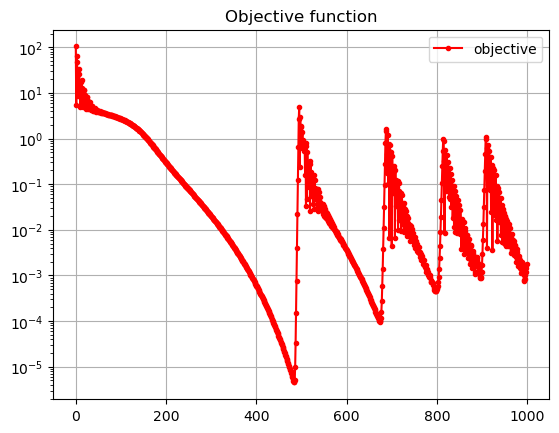

In [19]:
plt.semilogy(obs[:, 0], "r.-", label="objective")
plt.legend()
plt.grid()
plt.title("Objective function")

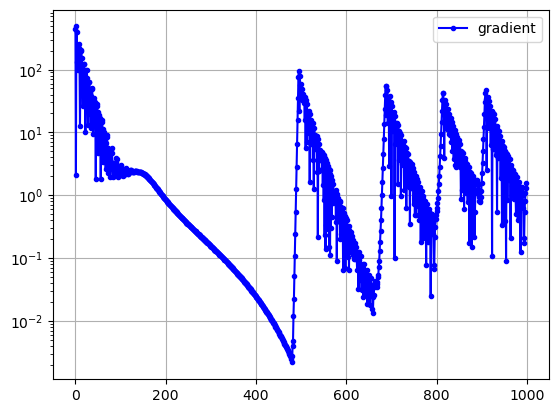

In [20]:
plt.semilogy(obs[:, 1], "b.-", label="gradient")
plt.legend()
plt.grid(True)

### Explanation
- no valid stopping criterium
- momentum leads to overshooting
- needs scheduled learning rate

# Scheduling
- decent into valley &rarr; small step sizes to avoid overshooting due to large gradients
- slowly increaing step sizes to move into right direction
- decay at the end to let the steps circle around optimum

# Stochastic gradient descent and batches

- $f(x), \frac{f(x)}{dx} \Rightarrow f_{\xi}(x), \frac{f_{\xi}(x)}{dx}$  going from deterministic functions to stochastic ones
- $f_{\xi}(x) = f(x)+\epsilon $, i.e. the deterministic function but with a small stochastic noise $\epsilon$
- each gradient over a full epoch &rarr; $\epsilon=0$
- smaller versus larger batches &rarr; $\epsilon_{small} > \epsilon_{large}$: the larger the batch, the smaller the noise + the better the gradients

## Random sampling
- avoids systematic errors and overfitting
- makes the expected mean small
- avoids cycling around the optimum


# Future "work" and research
- take the knowledge from *memory adjusted step size* further
- employ gradient rotation to smooth out zigzagging
- limiting *path following* to stay below a treshhold (avoid exploding gradients)
    - *path following* from Guddat et.al.: Parametric Optimization: Singularities, Pathfollowing and Jumps
- test on "stochastic Rosenbrock" to simulate the stochastic batches
- test on AutoEncoder

# Initialization or bootstrapping

**A neural network with all weights initialized to $0$ cannot learn using backpropagation.**

- assuming inputs to the left, outputs to the right
- a neuron/node in a hidden layer (aka between input and output) is connected with zero-weights to the previous ones, and with zero-weights to the subsequent nodes 
- the activation stays zero &rarr; the weights to the right cannot be adjusted due to zero-gradients from the neuron
- the summarized gradient from the right is zero, that means the gradient before the activation function stays zero &rarr; no weight adjustments on the left

## Winning ticket lottery paper

### Procedure

- take large model, randomly initialize, store the initial values somewhere
- train the network
- in several stages
    - prune the network deleting seldom active neurons and those with low weights
    - retrain
    - repeat until network is much much smaller
- take the small network and initialize with the stored values
- train
- obtain results that are similar to the large network

# Activation functions

- **ReLu** is bad for optimization due to the valley having a *kink* &rarr; stagnation is common
- ReLu is simple and fast for inference
- **GeLu** is good for optimization due to being smooth, but expensive to compute
- *Embedding* - technique where $t=0$ means having a "nice" function, while $t=1" represents the target function and there is a smooth transition.
   - *parametrized GeLu*, *Swish* and similar, when finetuning turning the parameter closer to 1

# Takk

kode er på https://github.com/matthias-p-nowak/rosenbrock.git
